Import required packages:

In [0]:
import pandas as pd
import sys
import os
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
import json
from keras import backend as K
from keras.utils import plot_model
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


Load data and prepare labels:

In [0]:
logs_labels = pd.read_csv("logs_labels.csv")

X = logs_labels.full_log
Y = logs_labels.label

Y = np.array([0 if i == 0 else 1 for i in Y])

Set variables:

In [0]:
batch_size = 64 
epochs = 10 
num_samples = 40000  
seed = 2809
max_log_length = 1024

Set random subset for training:

In [0]:
np.random.seed(seed)
sample_index = list(np.random.randint(0,len(X), size = (num_samples,)))
train_size = int(.75*len(sample_index))

Set up and fit characterizer using the Tokenizer class, and split data into train and test set:

In [0]:
tokenizer = Tokenizer(filters='', char_level=True)
tokenizer.fit_on_texts(X)
            
with open('word-dictionary.json', 'w') as outfile:
    json.dump(tokenizer.word_index, outfile, ensure_ascii=False)
    
X = tokenizer.texts_to_sequences(X)

X_processed = np.array(sequence.pad_sequences(X, maxlen=max_log_length))
X_train, X_test = X_processed[sample_index[:train_size]], X_processed[sample_index[train_size:]]
Y_train, Y_test = Y[sample_index[:train_size]], Y[sample_index[train_size:]]


Define F1-function to keep track of F1-score during training:

In [0]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Define model and print summary:

In [0]:
model = Sequential()
model.add(Embedding(num_words, 32, input_length=max_log_length))
model.add(Dropout(0.5))
model.add(LSTM(64, recurrent_dropout=0.5))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', f1])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1024, 32)          3008      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024, 32)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 27,905
Trainable params: 27,905
Non-trainable params: 0
_________________________________________________________________
None


Export model plot:

In [0]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=False)

Fit model:

In [0]:
history = model.fit(X_train, Y_train, validation_split=0.25, epochs=epochs, batch_size=batch_size)

Train on 22500 samples, validate on 7500 samples
Epoch 1/10
22500/22500 [==============================] - 1040s 46ms/step - loss: 0.1887 - acc: 0.9508 - f1: 0.6981 - val_loss: 0.0888 - val_acc: 0.9791 - val_f1: 0.9048
Epoch 2/10
22500/22500 [==============================] - 1035s 46ms/step - loss: 0.1015 - acc: 0.9754 - f1: 0.8840 - val_loss: 0.0805 - val_acc: 0.9796 - val_f1: 0.9087
Epoch 3/10
22500/22500 [==============================] - 1034s 46ms/step - loss: 0.0975 - acc: 0.9757 - f1: 0.8863 - val_loss: 0.0813 - val_acc: 0.9789 - val_f1: 0.9042
Epoch 4/10
22500/22500 [==============================] - 1034s 46ms/step - loss: 0.0934 - acc: 0.9766 - f1: 0.8944 - val_loss: 0.0823 - val_acc: 0.9796 - val_f1: 0.9085
Epoch 5/10
22500/22500 [==============================] - 1034s 46ms/step - loss: 0.0920 - acc: 0.9770 - f1: 0.8920 - val_loss: 0.0772 - val_acc: 0.9799 - val_f1: 0.9103
Epoch 6/10
22500/22500 [==============================] - 1035s 46ms/step - loss: 0.0905 - acc: 0.976

Save model configuration:

In [0]:
model.save("model.h5")

Predict probabilities and define false positive rates, true positive rates and thresholds for ROC plot:

In [0]:
probs = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(Y_test, probs, pos_label = 1)
roc_auc = auc(fpr,tpr)

Print area under ROC curve:

In [0]:
print(roc_auc)

0.9824539465666349

Plot ROC curve:

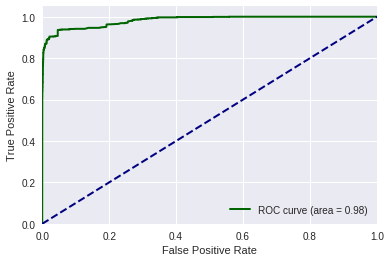

In [0]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkgreen',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

Turn predicted probabilities into labels and evaluate on test set:

In [0]:
Y_pred = [int(round(i[0])) for i in probs] 

In [0]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_pred))

             precision    recall  f1-score   support

          0       0.98      1.00      0.99      8717
          1       0.96      0.84      0.90      1283

avg / total       0.98      0.98      0.97     10000



Plot loss and F1-scores during training:

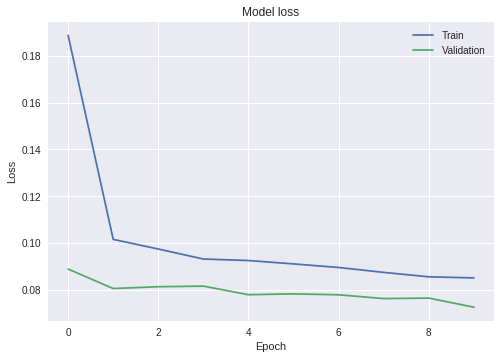

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

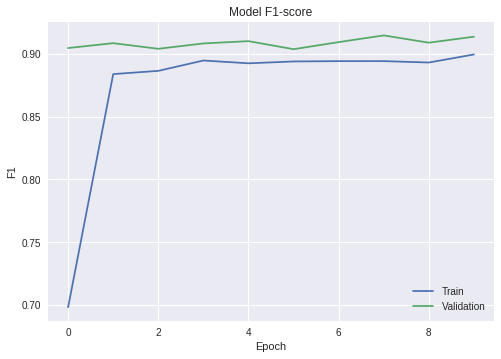

In [0]:
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('Model F1-score')
plt.ylabel('F1')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()